### Modelo de aprendizado de máquina para reconhecimento de imagens de frutas ou verduras

In [1]:
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

In [2]:
# Coeficiente de aleatoriedade
tf.random.set_seed(4)

In [3]:
# Caminho para dados de treino
caminho_dados_treino = Path('fruits-360/Training')
# Caminho para dados de teste
caminho_dados_teste = Path('fruits-360/Test')

In [4]:
# Listagem do conteúdo da pasta
imagens_treino = list(caminho_dados_treino.glob('*/*'))
# Extração de apenas o valor com o caminho de cada imagem (removendo PosixPath)
imagens_treino = list(map(lambda x: str(x), imagens_treino))
imagens_treino = list(map(lambda x: str(x).replace('\\', '/'), imagens_treino))

In [5]:
imagens_treino[925:936]
# O nome dos arquivos prejudica a compreensão

['fruits-360/Training/Apple Crimson Snow/r_90_100.jpg',
 'fruits-360/Training/Apple Crimson Snow/r_91_100.jpg',
 'fruits-360/Training/Apple Crimson Snow/r_92_100.jpg',
 'fruits-360/Training/Apple Crimson Snow/r_93_100.jpg',
 'fruits-360/Training/Apple Crimson Snow/r_94_100.jpg',
 'fruits-360/Training/Apple Crimson Snow/r_95_100.jpg',
 'fruits-360/Training/Apple Crimson Snow/r_96_100.jpg',
 'fruits-360/Training/Apple Crimson Snow/r_97_100.jpg',
 'fruits-360/Training/Apple Crimson Snow/r_98_100.jpg',
 'fruits-360/Training/Apple Crimson Snow/r_99_100.jpg',
 'fruits-360/Training/Apple Crimson Snow/r_9_100.jpg']

##### Pré-processamento de dados

In [6]:
# Obtenção do label de cada imagem
def extrai_label(caminho_imagem):
    return caminho_imagem.split("/")[-2]

imagens_treino_labels = list(map(lambda x: extrai_label(x), imagens_treino))

In [7]:
imagens_treino_labels[840:844]
# O sistema não reconhece strings, para isso, é necessário converte-la em números

['Apple Crimson Snow',
 'Apple Crimson Snow',
 'Apple Crimson Snow',
 'Apple Crimson Snow']

In [8]:
# Criação do objeto
encoder = LabelEncoder()

imagens_treino_labels = encoder.fit_transform(imagens_treino_labels)

# Aplicação do one-hot-encoding nos labels
imagens_treino_labels = tf.keras.utils.to_categorical(imagens_treino_labels)

In [9]:
# Divisão dos dados de treino e de validação
x_treino, x_valid, y_treino, y_valid = train_test_split(imagens_treino, imagens_treino_labels)

##### Dataset Augmentation

Consiste em modificar as imagens para que o modelo fique mais preciso em identificar

In [10]:
# Redimensionamento das imagens
img_size = 224
resize = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Resizing(img_size, img_size)])

# Criação do objeto do Data Augmentation
data_augmentation = tf.keras.Sequential([RandomFlip("horizontal"),
                                         RandomRotation(0.2),
                                         RandomZoom(height_factor = (-0.3,-0.2)) ])


##### Preparo dos dados

In [11]:
# Hiperparametros
batch_size = 32
autotune = tf.data.experimental.AUTOTUNE


In [12]:
# Carregamento e transformação de imagens
def carrega_transforma(image, label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels = 3)
    return image, label

In [13]:
# Preparação dos dados no formato do TensorFlow
# Dataset augmentation é usado apenas em treino
def prepara_dataset(path, labels, train = True):
    image_paths = tf.convert_to_tensor(path)
    labels = tf.convert_to_tensor(labels)
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    dataset = dataset.map(lambda image, label: carrega_transforma(image, label)) 
    dataset = dataset.map(lambda image, label: (resize(image), label), num_parallel_calls = autotune)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)

    # Se train = True aplica dataset augmentation
    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label), num_parallel_calls = autotune)
  
    # Se train = False repete sobre o dataset e retorna
    dataset = dataset.repeat()

    return dataset


In [14]:
# Criação do dataset de treino
dataset_treino = prepara_dataset(x_treino, y_treino)

In [15]:
# Shape
imagem, label = next(iter(dataset_treino))
print(imagem.shape) # "Lotes" de 32 imagens 224 x 244 de tamanho e 3 canais de cores (RGB)
print(label.shape) # 32 labels e um vetor de 131 itens na pasta

(32, 224, 224, 3)
(32, 131)


In [16]:
# Criação do dataset de validação
dataset_valid = prepara_dataset(x_valid, y_valid, train = False)

##### Construção do modelo

In [17]:
# Carregamento de um modelo pre-treinado
modelo_pre = EfficientNetB3(input_shape = (224, 224, 3), include_top = False)

In [18]:
# Adição das camadas ao modelo_pre
modelo = tf.keras.Sequential([modelo_pre,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(131, activation = 'softmax')])

In [19]:
# Sumario do modelo
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 131)               201347    
                                                                 
Total params: 10,984,882
Trainable params: 10,897,579
Non-trainable params: 87,303
_________________________________________________________________


In [20]:
# Hiperparâmetros
lr = 0.001
beta1 = 0.9
beta2 = 0.999
ep = 1e-07

In [21]:
# Compilação do modelo
modelo.compile(optimizer = Adam(learning_rate = lr, 
                                beta_1 = beta1, 
                                beta_2 = beta2, 
                                epsilon = ep),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])


In [22]:
%%time
#Treino do modelo
history = modelo.fit(dataset_treino,
                    steps_per_epoch = len(x_treino)//batch_size,
                    epochs = 1,
                    validation_data = dataset_valid,
                    validation_steps = len(y_treino)//batch_size)
# Leva horas para treinar, atenção

In [22]:
# Descarte
modelo.layers[0].trainable = False

# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint("modelo/modelo_frutas.h5", 
                                                verbose = 1, 
                                                save_best = True, 
                                                save_weights_only = True)

In [23]:
# Early stop
early_stop = tf.keras.callbacks.EarlyStopping(patience = 4) 

# Sumário
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 131)               201347    
                                                                 
Total params: 10,984,882
Trainable params: 201,347
Non-trainable params: 10,783,535
_________________________________________________________________


In [24]:
%%time
# Treino aperfeiçoado com as novas adições
history = modelo.fit(dataset_treino,
                     steps_per_epoch = len(x_treino)//batch_size,
                     epochs = 6,
                     validation_data = dataset_valid,
                     validation_steps = len(y_treino)//batch_size,
                     callbacks = [checkpoint, early_stop])


Epoch 1/6
  21/1586 [..............................] - ETA: 319:44:13 - loss: 4.0655 - accuracy: 0.2009 - precision: 0.7500 - recall: 0.0223

##### Avaliação do modelo

In [ ]:
# Para carregar os pesos, precisamos descongelar as camadas
modelo.layers[0].trainable = True   

# Carregamento dos pesos do ponto de verificação e reavaliação
modelo.load_weights("modelo/modelo_frutas.h5")     


In [ ]:
# Carregando e preparando os dados de teste
caminho_imagens_teste = list(caminho_dados_teste.glob("*/*"))
imagens_teste = list(map(lambda x: str(x), caminho_imagens_teste))
imagens_teste = list(map(lambda x: str(x).replace('\\', '/'), imagens_teste))
imagens_teste_labels = list(map(lambda x: extrai_label(x), imagens_teste))
imagens_teste_labels = encoder.fit_transform(imagens_teste_labels)
imagens_teste_labels = tf.keras.utils.to_categorical(imagens_teste_labels)
test_image_paths = tf.convert_to_tensor(imagens_teste)
test_image_labels = tf.convert_to_tensor(imagens_teste_labels)

In [ ]:
# Função para decode das imagens
def decode_imagens(image, label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [224,224], method = "bilinear")
    return image, label

In [ ]:
# Criação do dataset de teste
dataset_teste = (tf.data.Dataset
                 .from_tensor_slices((imagens_teste, imagens_teste_labels))
                 .map(decode_imagens)
                 .batch(batch_size))

# Shape
imagem, label = next(iter(dataset_teste))
print(imagem.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 131)


Apple Braeburn
709/709 [==============================] - 2266s 3s/step - loss: 33.7173 - accuracy: 0.0088 - precision: 0.0079 - recall: 0.0075
Acurácia:  0.008771156892180443
Precision:  0.007932458072900772
Recall:  0.007537024095654488


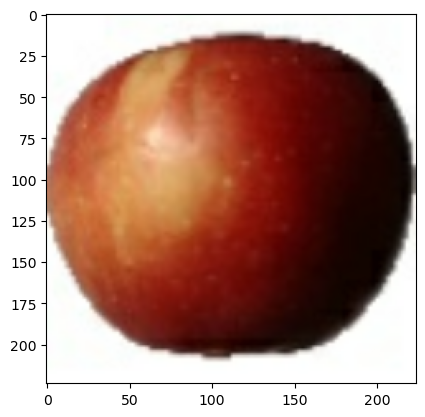

In [ ]:
# Visualização uma imagem de teste
print(encoder.inverse_transform(np.argmax(label, axis = 1))[0])
plt.imshow((imagem[0].numpy()/255).reshape(224,224,3))

# Avaliação do modelo
loss, acc, prec, rec = modelo.evaluate(dataset_teste)

print("Acurácia: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)

##### Previsão com o novo modelo

In [ ]:
# Função para carregar uma nova imagem
def carregamento_imagem(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [224,224], method = "bilinear")
    plt.imshow(image.numpy()/255)
    image = tf.expand_dims(image, 0) 
    return image


In [ ]:
# Função para fazer previsões
def previsao(image_path, model, enc):
    image = carregamento_imagem(image_path)
    prediction = model.predict(image)
    pred = np.argmax(prediction, axis = 1) 
    return enc.inverse_transform(pred)[0] 

1/1 [==============================] - 0s 119ms/step


'Strawberry'

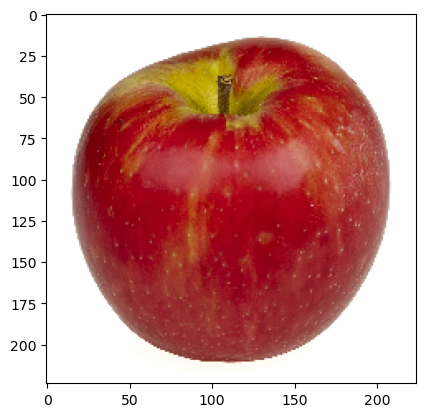

In [ ]:
# Previsão
previsao("imagens/imagem1.jpg", modelo, encoder)